# Welcome to the Data Analysis Notebook

## Comparing Explicit vs Implicit Data

This notebook is designed to **facilitate a comprehensive analysis** of simulation data derived from core-collapse astrophysical phenomena. Our focus will be on contrasting the outcomes and behaviors of two computational approaches: the **explicit** and the **implicit methods**. 

### Getting Started

Let's begin by loading in the parameters. These parameters have been created to reflect accurate core-collapse conditions.

### Reference Data

For a detailed overview of the conditions and parameters underlying our simulations, please refer to our tabulated data available:

- **Core Collapse Conditions Tabulated** at [Google Sheets](https://docs.google.com/spreadsheets/d/1VsG4Ois3iU9L2qE055nPuFae4Wk5DjTF_hNHd9PkECA/edit?usp=sharing)

### Contact

For any questions please reach out to **Raghav Chari** (rchari1@vols.utk.edu)


In [23]:
import re 
Model = 1 # Conditions Tabulated Above 
n_plotfiles = 86 # Please delcare the number of plotfiles for both your Explicit and Implicit data. We reccomend these be the same amount of plotfiles for consistency.
file_dir_explicit = "./OutputE" # Directory for Explicit Data
file_dir_implicit = "./OutputB" # Directory for Implicit Data
equilibrium_log_time = 2.5 # Set the equilibrium time in log10 scale
steps_E = 0 # Explicit Steps
steps_B = 0 # Implicit Steps
save_plots = False  # Set to True to save plots, or False to display only

# Now lets load in the initial conditions:

def load_simulation_parameters(log_file_path):
    parameters = {}
    scattering_kernel_types = {
    '1': r"$\nu_e + e^-$",  # Neutrino-Electron Scattering
    '2': r"$\bar{\nu}_e + e^-$",  # AntiNeutrino-Electron Scattering
    '3': r"$\bar{\nu}_{\mu,\tau} + \mu^-,\tau^-$",  # MuonTau-AntiNeutrino Scattering
    '4': r"$\nu_{\mu,\tau} + \mu^-,\tau^-$"  # Muon-Tau Neutrino Scattering
}


    with open(log_file_path, 'r') as file:
        for line in file:
            if ': ' in line:
                key, value = line.split(': ', 1)
                key = key.strip()
                value = value.strip()
                if key == 'Scattering Kernal':
                    value = scattering_kernel_types.get(value, "Unknown Scattering Type")
                parameters[key] = value
    
    return parameters

log_file_path = 'simulation_log.txt'
simulation_parameters = load_simulation_parameters(log_file_path)



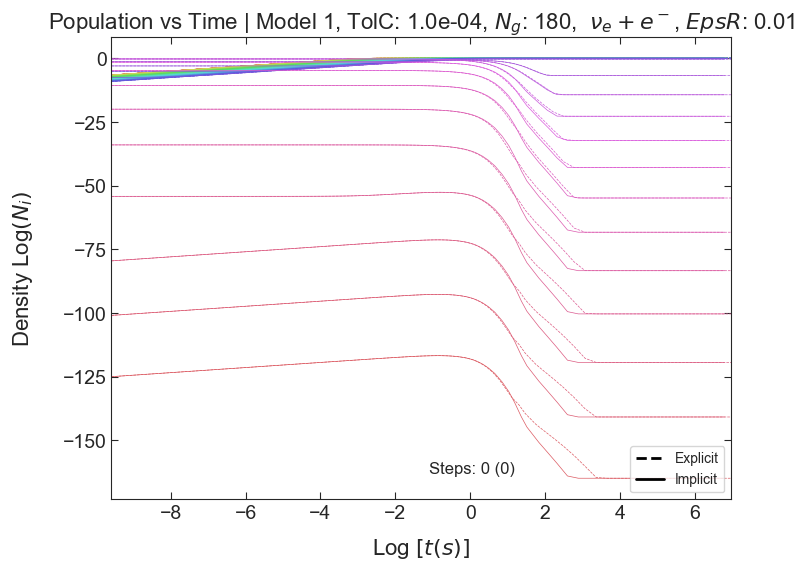

In [24]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

# Function to load data from files
def load_data(file_dir, file_prefix, num_files):
    t_values = []
    N_values = []
    for i in range(num_files):
        filename = os.path.join(file_dir, f"{file_prefix}_{i}")
        with open(filename, "r") as f:
            N = []
            for line in f:
                if line.startswith("t:"):
                    t = float(line.split(": ")[1])
                elif line.startswith("N:"):
                    N_line = line.split(": ")[1].strip()
                    N.append(np.array([float(x) for x in N_line.split()]))
        t_values.append(t)
        N_values.append(N)

    return np.array(t_values), np.array(N_values)

# Load explicit (C++) data
t_array_explicit, N_array_explicit = load_data(file_dir_explicit, "PlotFile", n_plotfiles)

# Load implicit (MATLAB) data
t_array_implicit, N_array_implicit = load_data(file_dir_implicit, "PlotFile", n_plotfiles)

# Apply log10 to the arrays
t_log_array_explicit = np.log10(t_array_explicit)
N_log_array_explicit = np.log10(N_array_explicit)
t_log_array_implicit = np.log10(t_array_implicit)
N_log_array_implicit = np.log10(N_array_implicit)

# Interpolate the explicit N_array to match implicit timesteps
N_array_explicit_interpolated = np.zeros(N_array_implicit.shape)
for i in range(N_array_explicit.shape[1]):
    for j in range(N_array_explicit.shape[2]):
        N_array_explicit_interpolated[:, i, j] = np.interp(t_array_implicit, t_array_explicit, N_array_explicit[:, i, j])

# Set up the plot
sns.set_style("white")
fig, ax = plt.subplots(figsize=(8, 6))

# Generate the 'colors' variable using hls_palette
num_colors = N_log_array_explicit.shape[2]
colors = sns.color_palette("hls", num_colors)

# Plot explicit data with dashed lines
for i in range(N_log_array_explicit.shape[2]):
    ax.plot(t_log_array_explicit[1:], N_log_array_explicit[1:, :, i], c=colors[i], alpha=0.98, linewidth=0.5, zorder=2, linestyle='--')

# Plot implicit data with straight lines
for i in range(N_log_array_implicit.shape[2]):
    ax.plot(t_log_array_implicit[1:], N_log_array_implicit[1:, :, i], c=colors[i], alpha=0.98, linewidth=0.5, zorder=2)

ax.set_xlabel("Log $[t(s)]$", fontsize=16, labelpad=10)
ax.set_ylabel("Density Log$(N_i)$", fontsize=16, labelpad=20)
ax.tick_params(axis='both', which='major', labelsize=14, length=5, direction='in', bottom=True, top=True, left=True, right=True)
ax.tick_params(axis='both', which='minor', length=2.5, direction='in', bottom=True, top=True, left=True, right=True)

tolC_value = simulation_parameters.get('Tolerance (TolC)', 'N/A')
# Check if tolC_value is not 'N/A', then convert to float and format to scientific notation
if tolC_value != 'N/A':
    tolC_value = "{:.1e}".format(float(tolC_value))
plot_title = f"Population vs Time | Model {Model}, "
plot_title += f"TolC: {tolC_value}, "
plot_title += f"$N_g$: {simulation_parameters.get('Number of Energy Groups (N_g)', 'N/A')}, "
plot_title += f" {simulation_parameters.get('Scattering Kernal', 'N/A')}, "
plot_title += f"$EpsR$: {simulation_parameters.get('Relative Error Tolerance (EpsR)', 'N/A')}"



ax.set_title(plot_title, fontsize=16)
custom_lines = [Line2D([0], [0], color='black', lw=2, linestyle='--'),
                Line2D([0], [0], color='black', lw=2)]

ax.legend(custom_lines, ['Explicit', 'Implicit'], loc='lower right')

ax.margins(x=0.00)

steps_text = f'Steps: {steps_E} ({steps_B})'
ax.text(0.65, 0.05, steps_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='bottom', horizontalalignment='right')

# Retrieve the plot title
plot_title = plt.gca().get_title()

# Make the title a suitable filename: Remove special characters, replace spaces with underscores, etc.
filename = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_') + '.eps'

# Save the figure

if save_plots:
    plt.savefig(filename, dpi=300, bbox_inches="tight")
else:
    plt.show()


<>:68: SyntaxWarning: invalid escape sequence '\e'
<>:76: SyntaxWarning: invalid escape sequence '\e'
<>:68: SyntaxWarning: invalid escape sequence '\e'
<>:76: SyntaxWarning: invalid escape sequence '\e'
/var/folders/tx/6c8d0pmx0gb00qgjwp8dkclm0000gn/T/ipykernel_63217/3700372124.py:68: SyntaxWarning: invalid escape sequence '\e'
  ax.set_ylabel("$\epsilon$", fontsize=16, labelpad=20)
/var/folders/tx/6c8d0pmx0gb00qgjwp8dkclm0000gn/T/ipykernel_63217/3700372124.py:76: SyntaxWarning: invalid escape sequence '\e'
  plot_title = f"$\epsilon$ vs Time | Model {Model}, "


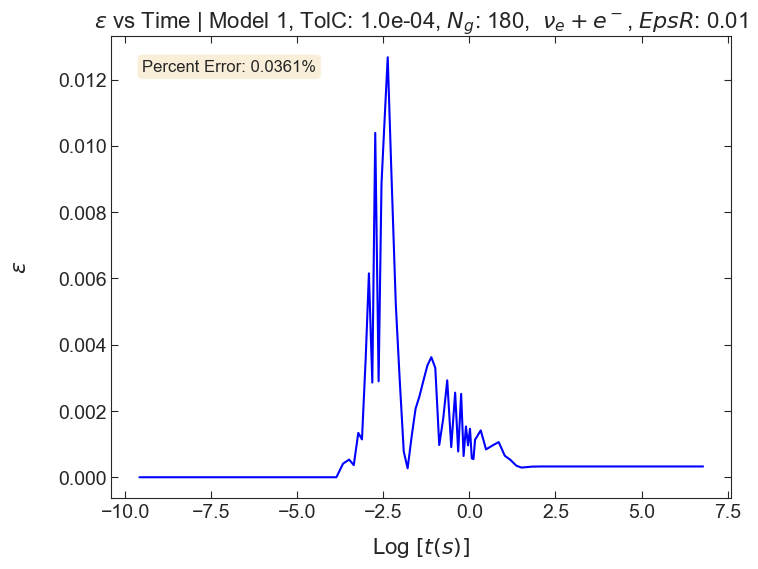

In [25]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def load_data(file_dir, file_prefix, num_files):
    t_values = []
    N_values = []
    for i in range(num_files):
        filename = os.path.join(file_dir, f"{file_prefix}_{i}")
        with open(filename, "r") as f:
            N = []
            for line in f:
                if line.startswith("t:"):
                    t = float(line.split(": ")[1])
                elif line.startswith("N:"):
                    N_line = line.split(": ")[1].strip()
                    N.append(np.array([float(x) for x in N_line.split()]))
        t_values.append(t)
        N_values.append(N)
    
    return np.array(t_values), np.array(N_values)

# Load data for explicit and implicit models
t_array_explicit, N_array_explicit = load_data(file_dir_explicit, "PlotFile", n_plotfiles)

t_array_implicit, N_array_implicit = load_data(file_dir_implicit, "PlotFile", n_plotfiles)

# Interpolate explicit data to match implicit timesteps
N_array_explicit_interpolated = np.zeros(N_array_implicit.shape)
for i in range(N_array_explicit.shape[1]): 
    for j in range(N_array_explicit.shape[2]):
        N_array_explicit_interpolated[:, i, j] = np.interp(t_array_implicit, t_array_explicit, N_array_explicit[:, i, j])

# Calculate RMS error
RMS_array = np.zeros((n_plotfiles,))
for i in range(1, n_plotfiles):
    R = N_array_implicit[i, :, :]
    A = N_array_explicit_interpolated[i, :, :]
    Res = np.abs(A - R) 
    RMS = np.sqrt(np.sum(Res**2) / np.prod(Res.shape))
    RMS_array[i] = RMS

# Convert to linear time scale from equilibrium_log_time
equilibrium_time = 10**equilibrium_log_time

# Find index for equilibrium time
equilibrium_index = np.searchsorted(t_array_implicit, equilibrium_time, side='right')

# Compute the time differences and total error up to the equilibrium time
t_diff = np.diff(t_array_implicit[:equilibrium_index])
error = np.sum(RMS_array[1:equilibrium_index] * t_diff)

# Normalize error by total time interval
total_time_interval = t_array_implicit[equilibrium_index-1] - t_array_implicit[0]
normalized_error = error / total_time_interval

# Convert normalized error to percentage
percent_error = normalized_error * 100

# Plotting RMS vs Time
t_log_array_implicit = np.log10(t_array_implicit)

sns.set_style("white")
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(t_log_array_implicit[1:], RMS_array[1:], c='blue')
ax.set_xlabel("Log $[t(s)]$", fontsize=16, labelpad=10)
ax.set_ylabel("$\epsilon$", fontsize=16, labelpad=20)
ax.tick_params(axis='both', which='major', labelsize=14, length=5, direction='in', bottom=True, top=True, left=True, right=True)
ax.tick_params(axis='both', which='minor', length=2.5, direction='in', bottom=True, top=True, left=True, right=True)

tolC_value = simulation_parameters.get('Tolerance (TolC)', 'N/A')
# Check if tolC_value is not 'N/A', then convert to float and format to scientific notation
if tolC_value != 'N/A':
    tolC_value = "{:.1e}".format(float(tolC_value))
plot_title = f"$\epsilon$ vs Time | Model {Model}, "
plot_title += f"TolC: {tolC_value}, "
plot_title += f"$N_g$: {simulation_parameters.get('Number of Energy Groups (N_g)', 'N/A')}, "
plot_title += f" {simulation_parameters.get('Scattering Kernal', 'N/A')}, "
plot_title += f"$EpsR$: {simulation_parameters.get('Relative Error Tolerance (EpsR)', 'N/A')}"



ax.set_title(plot_title, fontsize=16)


error_text = f'Percent Error: {percent_error:.4f}%'

text_x = 0.05  # X position in figure as a fraction of plot width
text_y = 0.95  # Y position in figure as a fraction of plot height
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# Place the text on the plot
ax.text(text_x, text_y, error_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)


# Retrieve the plot title
plot_title = plt.gca().get_title()

# Make the title a suitable filename: Remove special characters, replace spaces with underscores, etc.
filename = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_') + '.eps'

# Save the figure

if save_plots:
    plt.savefig(filename, dpi=300, bbox_inches="tight")
else:
    plt.show()

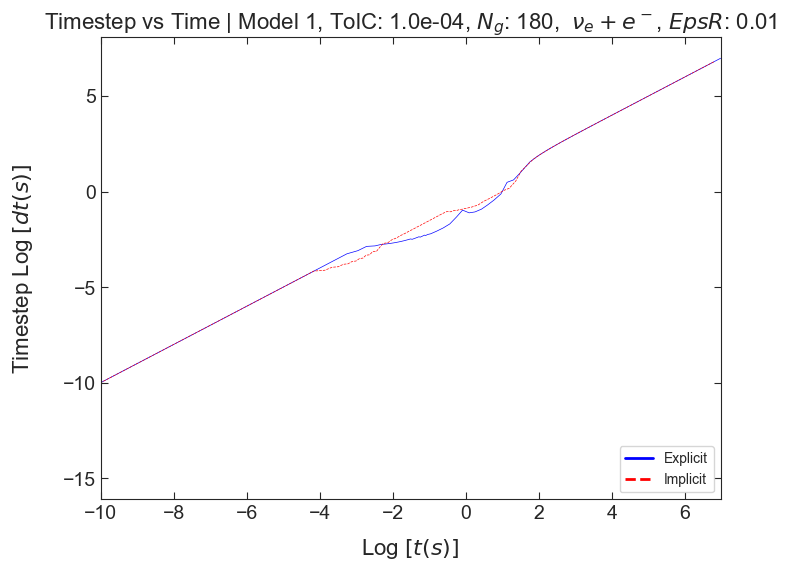

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

# Function to load data from files
def load_data(file_dir, file_prefix, num_files):
    t_values = []
    dt_values = []

    for i in range(num_files):
        filename = os.path.join(file_dir, f"{file_prefix}_{i}")
        
        with open(filename, "r") as f:
            for line in f:
                if line.startswith("t:"):
                    t = float(line.split(": ")[1])
                elif line.startswith("dt:"):
                    dt = float(line.split(": ")[1])
        t_values.append(t)
        dt_values.append(dt)
    
    return np.array(t_values), np.array(dt_values)

# Load explicit data
t_array_explicit, dt_array_explicit = load_data(file_dir_explicit, "PlotFile", n_plotfiles)

# Load implicit data
t_array_implicit, dt_array_implicit = load_data(file_dir_implicit, "PlotFile", n_plotfiles)

# Apply log10 to the arrays
t_log_array_explicit = np.log10(t_array_explicit)
dt_log_array_explicit = np.log10(dt_array_explicit)
t_log_array_implicit = np.log10(t_array_implicit)
dt_log_array_implicit = np.log10(dt_array_implicit)

# Set up the plot
sns.set_style("white")
fig, ax = plt.subplots(figsize=(8, 6))

# Plot explicit data
ax.plot(t_log_array_explicit, dt_log_array_explicit, c='blue', alpha=0.98, linewidth=0.5, zorder=2)

# Plot implicit data
ax.plot(t_log_array_implicit, dt_log_array_implicit, c='red', alpha=0.98, linewidth=0.5, zorder=2, linestyle='--')

ax.set_xlim([-10, max(t_log_array_explicit.max(), t_log_array_implicit.max())])

ax.set_xlabel("Log $[t(s)]$", fontsize=16, labelpad=10)
ax.set_ylabel("Timestep Log $[dt (s)]$", fontsize=16, labelpad=20)
ax.tick_params(axis='both', which='major', labelsize=14, length=5, direction='in', bottom=True, top=True, left=True, right=True)
ax.tick_params(axis='both', which='minor', length=2.5, direction='in', bottom=True, top=True, left=True, right=True)



tolC_value = simulation_parameters.get('Tolerance (TolC)', 'N/A')
# Check if tolC_value is not 'N/A', then convert to float and format to scientific notation
if tolC_value != 'N/A':
    tolC_value = "{:.1e}".format(float(tolC_value))
plot_title = f"Timestep vs Time | Model {Model}, "
plot_title += f"TolC: {tolC_value}, "
plot_title += f"$N_g$: {simulation_parameters.get('Number of Energy Groups (N_g)', 'N/A')}, "
plot_title += f" {simulation_parameters.get('Scattering Kernal', 'N/A')}, "
plot_title += f"$EpsR$: {simulation_parameters.get('Relative Error Tolerance (EpsR)', 'N/A')}"


ax.set_title(plot_title, fontsize=16)

# Create a custom legend with visual distinctions
custom_lines = [Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='red', lw=2, linestyle='--')]

ax.legend(custom_lines, ['Explicit', 'Implicit'], loc='lower right')

# Retrieve the plot title
plot_title = plt.gca().get_title()

# Make the title a suitable filename: Remove special characters, replace spaces with underscores, etc.
filename = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_') + '.eps'

# Save the figure

if save_plots:
    plt.savefig(filename, dpi=300, bbox_inches="tight")
else:
    plt.show()


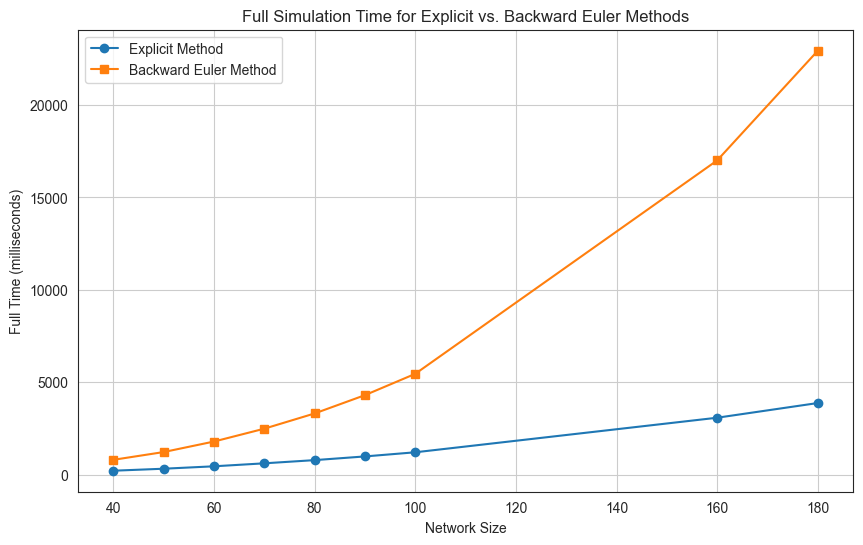

In [27]:
import matplotlib.pyplot as plt

network_sizes = [40, 50, 60, 70, 80, 90, 100, 160, 180]
full_time_explicit = [211, 319, 450, 611, 784, 984, 1208, 3078, 3873] # milliseconds
full_time_backward_euler = [800, 1220, 1789, 2484, 3308, 4298, 5451, 16997, 22931] # milliseconds

plt.figure(figsize=(10, 6))
plt.plot(network_sizes, full_time_explicit, marker='o', label='Explicit Method')
plt.plot(network_sizes, full_time_backward_euler, marker='s', label='Backward Euler Method')

plt.title('Full Simulation Time for Explicit vs. Backward Euler Methods')
plt.xlabel('Network Size')
plt.ylabel('Full Time (milliseconds)')
plt.legend()
plt.grid(True)
plt.show()


In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Define network sizes and times for each solver and method
network_sizes = np.array([40, 50, 60, 70, 80, 90, 100, 130, 160, 180])
full_time_explicit = np.array([211, 319, 450, 611, 784, 984, 1208, 2049, 3078, 3873])  # milliseconds
full_time_qr = np.array([874, 1328, 1895, 2647, 3461, 4501, 5714, 9643, 15604, 20646])  # milliseconds
full_time_cholesky = np.array([2205, 3463, 5431, 7998, 11207, 15173, 20044, 41092, 73308, 101942])  # milliseconds
full_time_lu = np.array([800, 1220, 1789, 2484, 3308, 4298, 5451, 10280, 16997, 22931])  # milliseconds

# Polynomial fit points
fit_points = 3

# Fitting polynomials to the initial points for trend estimation
p_explicit = np.polyfit(network_sizes[:fit_points], full_time_explicit[:fit_points], 2)
p_lu = np.polyfit(network_sizes[:fit_points], full_time_lu[:fit_points], 2)
p_cholesky = np.polyfit(network_sizes[:fit_points], full_time_cholesky[:fit_points], 2)
p_qr = np.polyfit(network_sizes[:fit_points], full_time_qr[:fit_points], 2)

# Generating network sizes for fitting lines
network_sizes_fit = np.linspace(network_sizes.min(), network_sizes.max(), 100)
fit_line_explicit = np.polyval(p_explicit, network_sizes_fit)
fit_line_lu = np.polyval(p_lu, network_sizes_fit)
fit_line_cholesky = np.polyval(p_cholesky, network_sizes_fit)
fit_line_qr = np.polyval(p_qr, network_sizes_fit)

# Plot 1: Full Simulation Time with Parabolic Fits
plt.figure(figsize=(10, 6))
plt.plot(network_sizes, full_time_explicit, 'o-', label='Explicit Method')
plt.plot(network_sizes, full_time_lu, 's-', color='purple', label='LU Solver')
plt.plot(network_sizes, full_time_cholesky, '^-', color='green', label='Cholesky Decomposition')
plt.plot(network_sizes, full_time_qr, 'x-', color='red', label='QR Decomposition')
plt.plot(network_sizes_fit, fit_line_explicit, 'r--', label='Fit Explicit Method')
plt.plot(network_sizes_fit, fit_line_lu, '--', color='purple', label='Fit LU Method')
plt.plot(network_sizes_fit, fit_line_cholesky, '--', color='green', label='Fit Cholesky Method')
plt.plot(network_sizes_fit, fit_line_qr, '--', color='red', label='Fit QR Method')
plt.title('Full Simulation Time with Parabolic Fits')
plt.xlabel('Network Size')
plt.ylabel('Full Time (milliseconds)')
plt.legend()
plt.grid(True)
plt.savefig('Parabolic_Fits.eps', format='eps')
plt.close()

# Plot 2: Full Simulation Time vs. Network Size Squared
plt.figure(figsize=(10, 6))
plt.plot(network_sizes**2, full_time_explicit, 'o-', label='Explicit Method')
plt.plot(network_sizes**2, full_time_lu, 's-', color='purple', label='LU Solver')
plt.plot(network_sizes**2, full_time_cholesky, '^-', color='green', label='Cholesky Decomposition')
plt.plot(network_sizes**2, full_time_qr, 'x-', color='red', label='QR Decomposition')
plt.title('Full Simulation Time vs. Network Size Squared')
plt.xlabel('Network Size Squared')
plt.ylabel('Full Time (milliseconds)')
plt.legend()
plt.grid(True)
plt.savefig('Network_Size_Squared.eps', format='eps')
plt.close()

# Plot 3: Plots without the fits
plt.figure(figsize=(10, 6))
plt.plot(network_sizes, full_time_explicit, 'o-', label='Explicit Method')
plt.plot(network_sizes, full_time_lu, 's-', color='purple', label='LU Solver')
plt.plot(network_sizes, full_time_cholesky, '^-', color='green', label='Cholesky Decomposition')
plt.plot(network_sizes, full_time_qr, 'x-', color='red', label='QR Decomposition')
plt.title('Simulation Time without Fits')
plt.xlabel('Network Size')
plt.ylabel('Full Time (milliseconds)')
plt.legend()
plt.grid(True)
plt.savefig('No_Fits.eps', format='eps')
plt.close()

# Plot 4: LU Solver Only vs Explicit
plt.figure(figsize=(10, 6))
plt.plot(network_sizes, full_time_explicit, 'o-', label='Explicit Method')
plt.plot(network_sizes, full_time_lu, 's-', color='purple', label='LU Solver')
plt.title('LU Solver vs. Explicit Method Comparison')
plt.xlabel('Network Size')
plt.ylabel('Full Time (milliseconds)')
plt.legend()
plt.grid(True)
plt.savefig('LU_vs_Explicit.eps', format='eps')
plt.close()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
